## Datos

In [1]:
# Librerías y paquetes
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
import colorednoise as cn
import random 
import pickle as pkl
from tqdm import tqdm
from pathlib import Path

## Generación de ruido gauseano

In [2]:
#Generador de ondas gravitacionales con ruido gausiano
def make_gravitational_waves(
    path_to_data: Path,
    n_signals: int = 30,
    downsample_factor: int = 2,
    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 10,
        ):
    
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        rand1 = np.random.randn(cut)
        rand2 = np.random.randn(n - cut)
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return out

    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad = 500  # number of padding points on either side of the vector
    #gw = np.load(path_to_data / "gravitational_wave_signals.npy")
    #../input/gravitational-wave-signals/gravitational_wave_signals.npy
    gw = np.load("gravitational_wave_signals.npy")
    Norig = len(gw["data"][0])
    Ndat = len(gw["signal_present"])
    N = int(Norig / downsample_factor)

    ncoeff = []
    Rcoeflist = []

    for j in range(n_signals):
        ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))
        Rcoeflist.append(Rcoef[j % n_snr_values])

    noisy_signals = []
    gw_signals = []
    k = 0
    labels = np.zeros(n_signals)

    for j in range(n_signals):
        signal = gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        sigp = int((np.random.randn() < 0))
        noise = ncoeff[j] * np.random.randn(N)
        labels[j] = sigp
        if sigp == 1:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
            if k == 0:
                k = 1
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
        noisy_signals.append(rawsig.copy())
        gw_signals.append(signal)

    return noisy_signals, gw_signals, labels

In [3]:
#from data.generate_datasets import make_gravitational_waves
from pathlib import Path

n_signals = 1500
DATA = Path("./data")

#Generar datos con ruido gausiano
noisy_gausignals, gw_gausignals, gau_labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=0.075, r_max=0.65, n_snr_values=100
)

# Onda gravitacional con ruido 
noisy_gausignals = (noisy_gausignals -  np.mean(noisy_gausignals)) / np.std(noisy_gausignals)
# Onda gravitacional sin ruido 
gw_gausignals =  (gw_gausignals -  np.mean(gw_gausignals)) / np.std(gw_gausignals)

print(f"Number of noisy signals: {len(noisy_gausignals)}")
print(f"Number of timesteps per series: {len(noisy_gausignals[0])}")

Number of noisy signals: 1500
Number of timesteps per series: 8692


In [4]:
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# get the index corresponding to the first pure noise time series
background_idx = np.argmin(gau_labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(gau_labels)

ts_noise = noisy_gausignals[background_idx] # vector de ruido solo
ts_background = noisy_gausignals[signal_idx] # vector de onda gravitacional con ruido 
ts_signal = gw_gausignals[signal_idx] # vector de onda sin ruido

fig = make_subplots(rows=1, cols=2)

# Grafica de ruido gauseano generado 
fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

# Grafica de onda gravitacional sin ruido 
fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

# Grafica de onda gravitacional con ruido 
fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()

## TDA

In [5]:
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding
from sklearn.decomposition import PCA

embedding_dimension = 50
embedding_time_delay = 10
stride = 20

embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=stride)


takens = embedder.fit_transform(noisy_gausignals)

In [6]:
persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)

scaling = Scaler()

persistencia = persistence.fit_transform(takens)

In [7]:
# Initialize an empty list to store concatenated characteristics for each wave
concat_pers = []

# Iterate through each wave
for wave in persistencia:
    # Extract and concatenate characteristics for the current wave
    first_characteristic = wave[:, 0]
    second_characteristic = wave[:, 1]
    third_characteristic = wave[:, 2]
    
    concat_per = np.concatenate((first_characteristic, second_characteristic, third_characteristic))
    concat_pers.append(concat_per)

# Convert the list of concatenated waves to a NumPy array
concat_pers = np.array(concat_pers)

In [8]:
cnn_data = []
for onda in range(len(noisy_gausignals)):
    concat_data = np.concatenate((noisy_gausignals[onda], concat_pers[onda]))
    cnn_data.append(concat_data)
cnn_data = np.array(cnn_data)

## CNN

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
data = np.array(cnn_data)

# Convert the data end labels to PyTorch tensors
data = torch.tensor(data, dtype=torch.float32).to(device)
labels = torch.tensor(gau_labels, dtype=torch.float32).to(device)


#Unsqueeze the data to add a channel dimension
data = data.unsqueeze(1)

# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)


# Create TensorDatasets for training and testing
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Shape of the data
print(f"Shape of the training data: {train_data.shape}")

Shape of the training data: torch.Size([1200, 1, 13963])


In [13]:
class GWCNN(nn.Module):
    def __init__(self):
        super(GWCNN, self).__init__()
      # First convolution block
        self.conv1 = nn.Conv1d(1, 16, kernel_size=16, stride=1)
        self.bnn1 = nn.BatchNorm1d(16)
        self.act1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=4)
        #self.fc1 = nn.Linear(2165, 512)  # 'reduced_dim1' needs to be calculated
    

        # Second convolution block
        self.conv2 = nn.Conv1d(16, 32, kernel_size=16, stride=1, padding=1)
        self.bnn2 = nn.BatchNorm1d(32)
        self.act2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=4, padding=0)
        #self.fc2 = nn.Linear(125, 128)  # 'reduced_dim2' needs to be calculated
      

        # Flattening for final dense layers
        self.flatten = nn.Flatten()
        self.fc5 = nn.Linear(27808, 512)
        self.act5 = nn.ReLU()
        self.fc6 = nn.Linear(512, 128)
        self.act6 = nn.ReLU()
        self.fc7 = nn.Linear(128, 32)
        self.act7 = nn.ReLU()
        self.fc8 = nn.Linear(32, 2)


    def forward(self, x):
        
        # First convolution block
        x = self.conv1(x)
        x = self.bnn1(x)
        x = self.act1(x)
        #x = self.fc1(x)
        x = self.maxpool1(x)
      
        #print("Bloque 1: ", x.shape)

        # Second convolution block
        x = self.conv2(x)
        x = self.bnn2(x)
        x = self.act2(x)
        x = self.maxpool2(x)
        #x = self.fc2(x)
        #print("Bloque 2: ", x.shape)
        
        # Flattening for final dense layers
        x = self.flatten(x)
        
        x = self.fc5(x)
        x = self.act5(x)
      
        x = self.fc6(x)
        x = self.act6(x)

        x = self.fc7(x)
        x = self.act7(x)

        x = self.fc8(x)
        #print("GG")
        return x

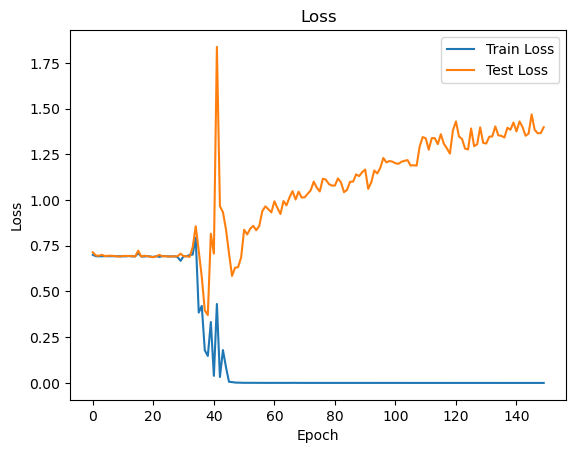

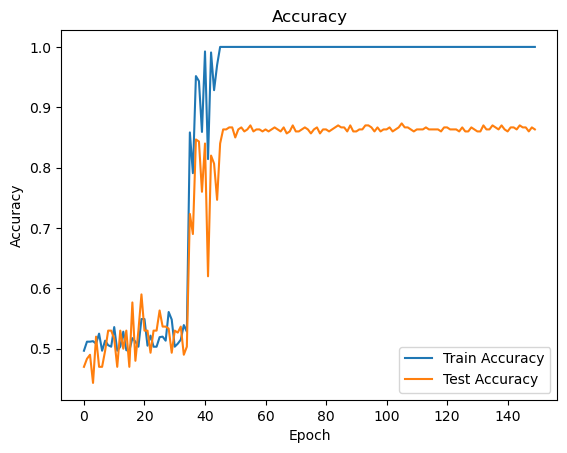

In [14]:
# Assuming your GWCNN model, train_loader, and test_loader are already defined
model = GWCNN().to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Function to calculate accuracy
def calculate_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Function to calculate loss
def calculate_loss(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.long())
            total_loss += loss.item()
    return total_loss / len(loader)

# Training loop
n_epochs = 150
for epoch in range(n_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels.long())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate and store train and test loss
    train_loss = calculate_loss(train_loader)
    test_loss = calculate_loss(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    # Calculate and store train and test accuracy
    train_accuracy = calculate_accuracy(train_loader)
    test_accuracy = calculate_accuracy(test_loader)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot the loss
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the accuracy
plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Save the trained model
# torch.save(model.state_dict(), "GW_Paper.pth")


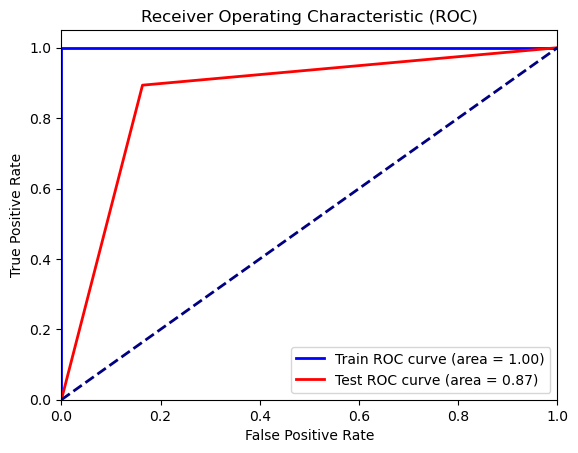

In [15]:
from sklearn.metrics import roc_curve, auc

# Suponiendo que ya has entrenado tu modelo como en tu código proporcionado

# Función para obtener las predicciones y etiquetas verdaderas
def get_predictions_and_labels(loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return all_labels, all_preds

# Obtener predicciones y etiquetas para los datos de entrenamiento
train_labels, train_preds = get_predictions_and_labels(train_loader)

# Obtener predicciones y etiquetas para los datos de prueba
test_labels, test_preds = get_predictions_and_labels(test_loader)

# Calcular las curvas ROC
fpr_train, tpr_train, _ = roc_curve(train_labels, train_preds)
fpr_test, tpr_test, _ = roc_curve(test_labels, test_preds)

# Calcular las áreas bajo la curva (AUC)
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plotear las curvas ROC
plt.figure()

plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (area = {auc_test:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [16]:
#test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted = predicted.cpu().numpy()
        print(predicted)


print(f"Accuracy: {100 * correct / total}")

[1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1]
[0 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0]
[0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1]
[0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1]
[0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0]
[0 1 0 0 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1]
[1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1]
[1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0]
[0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 1]
[0 1 0 0 0 1 1 1 0 1 1 1]
Accuracy: 86.33333333333333


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import kmapper as km
from kmapper.jupyter import display
import sklearn
from itertools import product


lay1 = model.conv2.weight
lay1 = lay1.detach().cpu().numpy()
lay1 = lay1[:, 0, :]
scaler = StandardScaler()
print(scaler.fit(lay1))
lay1_std = scaler.transform(lay1)
def density_filtration(X, k, p):
    """
    Perform density filtration on a set of points X.
    
    Parameters:
    X (numpy.ndarray): Input array of shape (n_samples, n_features).
    k (int): Number of nearest neighbors to consider.
    p (float): Percentage of points to select based on highest density (0 < p <= 100).
    
    Returns:
    numpy.ndarray: Subset of X with the highest density.
    """
    # Ensure p is between 0 and 100
    if not (0 < p <= 100):
        raise ValueError("p should be between 0 and 100")

    # Compute the k-th nearest neighbor distances for each point
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, _ = nbrs.kneighbors(X)
    rho_k = distances[:, -1]  # Distance to the k-th nearest neighbor
    
    # Calculate the density as the inverse of the distance
    densities = 1 / rho_k
    
    # Determine the threshold for the top p percent densities
    threshold = np.percentile(densities, 100 - p)
    
    # Select the points with densities greater than or equal to the threshold
    core_subset = X[densities >= threshold]
    
    return core_subset



k = 5  # 5th nearest neighbor
p = 10  # Top 10 percent of points by density

core_subset = density_filtration(lay1_std, k, p)

print("Core subset of points:")
print(core_subset)

mapper = km.KeplerMapper(verbose=1)
#projection=[manifold.Isomap(n_components=100, n_jobs=-1), umap.UMAP(n_components=2)]
projected_data = mapper.fit_transform(lay1, projection=[0])
covering = km.Cover(n_cubes=30, perc_overlap=0.8)
gg = mapper.map(projected_data, lay1, clusterer=sklearn.cluster.KMeans(n_clusters=2), cover = covering)

cub = [10, 20, 50, 69, 89, 100, 200]
ovs = [0.75, 0.85]

 
def cartesian_product(arr1, arr2):
 
    # return the list of all the computed tuple
    # using the product() method
    return list(product(arr1, arr2)) 

pairings = cartesian_product(cub, ovs)

for i, (cu, ov) in enumerate(pairings):
    covering = km.Cover(n_cubes=cu, perc_overlap=ov)
    gg = mapper.map(projected_data, lay1_std, clusterer=sklearn.cluster.KMeans(n_clusters=4), cover = covering)
    mapper.visualize(gg, path_html=f"make_circles_keplermapper_output cubes{cu} overl {ov}.html",
                     title="make_circles(n_samples=5000, noise=0.03, factor=0.3)")

StandardScaler()
Core subset of points:
[[ 1.46989554e-01  8.41896653e-01  3.63799870e-01  5.70532680e-01
   1.11184680e+00  8.88050854e-01  1.30575395e+00  1.03223240e+00
   9.08457398e-01 -2.39489786e-02  1.03728771e+00  1.31112158e+00
   1.46140683e+00  1.35015619e+00 -1.93577975e-01 -1.02858823e-02]
 [-7.44537532e-01 -1.38537371e+00 -2.21462563e-01 -4.64990020e-01
  -2.20774040e-01  5.35676241e-01 -1.48903981e-01  9.80792165e-01
   1.13064575e+00  7.48235822e-01  3.16871196e-01  6.48641109e-01
   4.45133120e-01  6.37492716e-01  8.85142505e-01  2.02372670e-01]
 [-7.80175209e-01  1.61129579e-01  2.19182506e-01 -4.31655973e-01
  -2.75592268e-01  4.28311676e-01  1.48540127e+00  1.64849088e-01
   1.52945518e+00  1.41359735e+00  2.93652211e-05  6.35252476e-01
   1.26517236e+00  7.19863296e-01  4.06019866e-01  5.31958938e-01]
 [-2.08296925e-01 -8.56928945e-01 -6.52663827e-01 -6.53784454e-01
  -5.85334480e-01  3.62111419e-01 -1.09225705e-01  8.36814046e-01
   1.36819839e+00 -3.31034571e-01

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e


Created 143 edges and 50 nodes in 0:00:01.336823.
Mapping on data shaped (32, 16) using lens shaped (32, 1)

Creating 10 hypercubes.


c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e


Created 78 edges and 36 nodes in 0:00:00.528279.
Wrote visualization to: make_circles_keplermapper_output cubes10 overl 0.75.html
Mapping on data shaped (32, 16) using lens shaped (32, 1)

Creating 10 hypercubes.


c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e


Created 169 edges and 40 nodes in 0:00:00.605961.
Wrote visualization to: make_circles_keplermapper_output cubes10 overl 0.85.html
Mapping on data shaped (32, 16) using lens shaped (32, 1)

Creating 20 hypercubes.


c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e


Created 93 edges and 48 nodes in 0:00:00.721916.
Wrote visualization to: make_circles_keplermapper_output cubes20 overl 0.75.html
Mapping on data shaped (32, 16) using lens shaped (32, 1)

Creating 20 hypercubes.


c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e


Created 259 edges and 64 nodes in 0:00:00.976090.
Wrote visualization to: make_circles_keplermapper_output cubes20 overl 0.85.html
Mapping on data shaped (32, 16) using lens shaped (32, 1)

Creating 50 hypercubes.


c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e


Created 88 edges and 56 nodes in 0:00:00.812631.
Wrote visualization to: make_circles_keplermapper_output cubes50 overl 0.75.html
Mapping on data shaped (32, 16) using lens shaped (32, 1)

Creating 50 hypercubes.


c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e


Created 319 edges and 92 nodes in 0:00:01.359210.
Wrote visualization to: make_circles_keplermapper_output cubes50 overl 0.85.html
Mapping on data shaped (32, 16) using lens shaped (32, 1)

Creating 69 hypercubes.


c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e


Created 75 edges and 52 nodes in 0:00:00.910353.
Wrote visualization to: make_circles_keplermapper_output cubes69 overl 0.75.html
Mapping on data shaped (32, 16) using lens shaped (32, 1)

Creating 69 hypercubes.


c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e


Created 333 edges and 104 nodes in 0:00:01.626993.
Wrote visualization to: make_circles_keplermapper_output cubes69 overl 0.85.html
Mapping on data shaped (32, 16) using lens shaped (32, 1)

Creating 89 hypercubes.


c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e


Created 37 edges and 36 nodes in 0:00:00.582597.
Wrote visualization to: make_circles_keplermapper_output cubes89 overl 0.75.html
Mapping on data shaped (32, 16) using lens shaped (32, 1)

Creating 89 hypercubes.


c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e


Created 275 edges and 92 nodes in 0:00:01.347595.
Wrote visualization to: make_circles_keplermapper_output cubes89 overl 0.85.html
Mapping on data shaped (32, 16) using lens shaped (32, 1)

Creating 100 hypercubes.


c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e


Created 27 edges and 32 nodes in 0:00:00.541532.
Wrote visualization to: make_circles_keplermapper_output cubes100 overl 0.75.html
Mapping on data shaped (32, 16) using lens shaped (32, 1)

Creating 100 hypercubes.


c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e


Created 250 edges and 84 nodes in 0:00:01.212524.
Wrote visualization to: make_circles_keplermapper_output cubes100 overl 0.85.html
Mapping on data shaped (32, 16) using lens shaped (32, 1)

Creating 200 hypercubes.

Created 11 edges and 12 nodes in 0:00:00.191785.


c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e

Wrote visualization to: make_circles_keplermapper_output cubes200 overl 0.75.html
Mapping on data shaped (32, 16) using lens shaped (32, 1)

Creating 200 hypercubes.


c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\jmanu\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e


Created 77 edges and 40 nodes in 0:00:00.583799.
Wrote visualization to: make_circles_keplermapper_output cubes200 overl 0.85.html
